### Table of Contents

* [Chapter 1 : Image Processing](#chapter1)
    * [Step 1 : Download Images](#section_1)
    * [Section 1.1 : Import and Config](#section_1_1)
    * [Section 1.2](sSection_1_2)
        * [Section 1.2.1](#section_1_2_1)
        * [Section 1.2.2](#section_1_2_2)
        * [Section 1.2.3](#section_1_2_3)

# Facade Parsing using Image Segmentation
Summary :   
## Chapter 1 - Image processing<a class="anchor" id="chapter1"></a>
Chapter Summary: The process is not entirely automated. Users are therefore responsible for filtering out the bette-viewed images from the extracted images.  
Author :  
Date :   



### Step 1: Download Panoramas from Google Street View<a class="anchor" id="section_1"></a>


In [ ]:
# -*- coding: utf-8 -*-
"""
Original code is from https://github.com/robolyst/streetview
Functions added in this file are
download_panorama_v1, download_panorama_v2, download_panorama_v3
Usage: 
    given latitude and longitude
    panoids = panoids( lat, lon )
    panoid = panoids[0]['panoid']
    panorama_img = download_panorama_v3(panoid, zoom=2)
"""

# https://github.com/cplusx/google-street-view-panorama-download/blob/master/streetview.py

#### 1.1 - Import and Config<a class="anchor" id="section_1_1"></a>

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Package import
import cv2 
import geopandas as gps
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import requests
import shapely.geometry
import shapefile
import sys

# Module import
from IPython.display import Image, display
from shapely.geometry import Polygon, Point, LineString
#from skimage import io

# Local imports
from src import streetview 


In [3]:
# https://gist.github.com/jeromer/2005586
# LICENSE: public domain

def get_bearing(pointA, pointB):
    pointA = pointA.coords[0]
    pointB = pointB.coords[0]
    if (type(pointA) != tuple) or (type(pointB) != tuple):
        raise TypeError("Only tuples are supported as arguments")

    lat1 = math.radians(pointA[0])
    lat2 = math.radians(pointB[0])

    diffLong = math.radians(pointB[1] - pointA[1])

    x = math.sin(diffLong) * math.cos(lat2)
    y = math.cos(lat1) * math.sin(lat2) - (math.sin(lat1)
            * math.cos(lat2) * math.cos(diffLong))

    initial_bearing = math.atan2(x, y)

    # Now we have the initial bearing but math.atan2 return values
    # from -180° to + 180° which is not what we want for a compass bearing
    # The solution is to normalize the initial bearing as shown below
    initial_bearing = math.degrees(initial_bearing)
    compass_bearing = (initial_bearing + 360) % 360

    return compass_bearing


def create_checker(point, angle, length):
    coordinates = point.coords[0]
    # unpack the first point
    x, y = coordinates
    # find the end point
    endy = y + length * math.cos(math.radians(angle))
    endx = x + length * math.sin(math.radians(angle))
    line = LineString([Point(x,y),Point(endx,endy)])
    return line

def find_building(gdf,checker):
    buildings_geometry = gdf.geometry
    for i in range(len(buildings_geometry)):
        building = buildings_geometry[i]
        if checker.intersects(building):
            building_id = gdf.iloc[i,1]
            return building_id
class Equirectangular:
    def __init__(self, img_name):
        self._img = cv2.imread(img_name,  cv2.IMREAD_COLOR)
        [self._height, self._width, _] = self._img.shape
        #cp = self._img.copy()  
        #w = self._width
        #self._img[:, :w/8, :] = cp[:, 7*w/8:, :]
        #self._img[:, w/8:, :] = cp[:, :7*w/8, :]
    def GetPerspective(self, FOV, THETA, PHI, height, width, RADIUS = 128):
        # THETA is left/right angle, PHI is up/down angle, both in degree
        equ_h = self._height
        equ_w = self._width
        equ_cx = (equ_w - 1) / 2.0
        equ_cy = (equ_h - 1) / 2.0

        wFOV = FOV
        hFOV = float(height) / width * wFOV

        c_x = (width - 1) / 2.0
        c_y = (height - 1) / 2.0

        wangle = (180 - wFOV) / 2.0
        w_len = 2 * RADIUS * np.sin(np.radians(wFOV / 2.0)) / np.sin(np.radians(wangle))
        w_interval = w_len / (width - 1)

        hangle = (180 - hFOV) / 2.0
        h_len = 2 * RADIUS * np.sin(np.radians(hFOV / 2.0)) / np.sin(np.radians(hangle))
        h_interval = h_len / (height - 1)
        x_map = np.zeros([height, width], float) + RADIUS
        y_map = np.tile((np.arange(0, width) - c_x) * w_interval, [height, 1])
        z_map = -np.tile((np.arange(0, height) - c_y) * h_interval, [width, 1]).T
        D = np.sqrt(x_map**2 + y_map**2 + z_map**2)
        xyz = np.zeros([height, width, 3], float)
        xyz[:, :, 0] = (RADIUS / D * x_map)[:, :]
        xyz[:, :, 1] = (RADIUS / D * y_map)[:, :]
        xyz[:, :, 2] = (RADIUS / D * z_map)[:, :]
        
        y_axis = np.array([0.0, 1.0, 0.0], float)
        z_axis = np.array([0.0, 0.0, 1.0], float)
        [R1, _] = cv2.Rodrigues(z_axis * np.radians(THETA))
        [R2, _] = cv2.Rodrigues(np.dot(R1, y_axis) * np.radians(-PHI))

        xyz = xyz.reshape([height * width, 3]).T
        xyz = np.dot(R1, xyz)
        xyz = np.dot(R2, xyz).T
        lat = np.arcsin(xyz[:, 2] / RADIUS)
        lon = np.zeros([height * width], float)
        theta = np.arctan(xyz[:, 1] / xyz[:, 0])
        idx1 = xyz[:, 0] > 0
        idx2 = xyz[:, 1] > 0

        idx3 = ((1 - idx1) * idx2).astype(bool)
        idx4 = ((1 - idx1) * (1 - idx2)).astype(bool)
        
        lon[idx1] = theta[idx1]
        lon[idx3] = theta[idx3] + np.pi
        lon[idx4] = theta[idx4] - np.pi

        lon = lon.reshape([height, width]) / np.pi * 180
        lat = -lat.reshape([height, width]) / np.pi * 180
        lon = lon / 180 * equ_cx + equ_cx
        lat = lat / 90 * equ_cy + equ_cy
        #for x in range(width):
        #    for y in range(height):
        #        cv2.circle(self._img, (int(lon[y, x]), int(lat[y, x])), 1, (0, 255, 0))
        #return self._img 
        persp = cv2.remap(self._img, lon.astype(np.float32), lat.astype(np.float32), cv2.INTER_CUBIC, borderMode=cv2.BORDER_WRAP)
        return persp

#### 1.2 - Download all panorama near to the given location<a class="anchor" id="section_1_2"></a>

In [ ]:
# User Inputs
lat_in = 57.7003612
lon_in = 11.9825506
fov= 120 # can vary but it quite good to start with
pitch= 0 # can be vary depending on buildings
height = 1000 # for large building and 720 for small buildings
width = 1000 # pretty goog to strart with
# Create helper to select result images
pano_sequence = 0

In [13]:
def get_image(lat=lat_in,lon=lon_in,pano_sequence = pano_sequence,fov=fov,pitch = pitch, height = height,width = width):
    panoids = streetview.panoids(lat=lat_in, lon=lon_in)
    panoid = panoids[pano_sequence]['panoid']
    lat = panoids[pano_sequence]['lat']
    lon = panoids[pano_sequence]['lon']
    panorama = streetview.download_panorama_v3(panoid, zoom=2, disp=False)
    # Save image
    rgbImg = cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB)
    im_path = "data/img/Panorama_image.jpg"
    cv2.imwrite(im_path, rgbImg)
    # save the entire JSON response as a geojson for outside use
    json_path = 'data/json/gsvp_data.json'
    with open(json_path, 'w') as outfile:
        json.dump(panoids, outfile)
    # Load Buildings
    gdf = gps.read_file("data/shp/hedasgatan.shp")
    gdf = gdf.set_crs('EPSG:4326')

    # Load camera positions
    array_data = json.load(open('data/json/gsvp_data.json'))
    df_camera = pd.json_normalize(array_data)
    gdf_camera = gps.GeoDataFrame(
        df_camera, geometry=gps.points_from_xy(df_camera.lon, df_camera.lat),crs = 'EPSG:4326')

    gdf = gdf.to_crs('EPSG:3006')
    gdf_camera = gdf_camera.to_crs('EPSG:3006')
    # Change marker visualisation for plot
    c = [] # color
    s = [] # size
    a = [] # alpha - Transparancy
    
    for id in list(gdf_camera['panoid']):
        if id == panoid:
            c.append('red')
            s.append(100)
            a.append(1) 
        else:
            c.append('blue')
            s.append(10)
            a.append(0.5)

    d = {'lon': [lon], 'lat': [lat]}
    df_current_point = pd.DataFrame(data=d)
    gdf_current_point = gps.GeoDataFrame(df_current_point,
                                         geometry=gps.points_from_xy(df_current_point.lon
                                                                     , df_current_point.lat),
                                         crs = 'EPSG:4326')
    gdf_current_point = gdf_current_point.to_crs('EPSG:3006')
    current_point = gdf_current_point.iloc[0,2]
    gdf_street = gps.read_file("data/shp/roads.shp")
    gdf_street = gdf_street.to_crs('EPSG:3006')
    polygon_index = gdf_street.distance(current_point).sort_values().index[0]
    street = gdf_street.loc[polygon_index]
    start,end = Point(street.geometry.coords[0]), Point(street.geometry.coords[-1])
    camera_direction = get_bearing(end,start)
    right = (camera_direction+90) %360
    left = (camera_direction+270) %360
    camera_direction,left,right
    equ = Equirectangular(im_path)
    length = 30
    n = 0 
    # Plot
    building_ids = []
    checkers = []
    for heading in [left,right]:
        checker = create_checker(current_point,heading,length)
        checkers.append(checker)
        building_id = find_building(gdf,checker)
        building_ids.append(building_id)
    i = 0
    uid = 1000
    for heading in [270, 90]:
        checker = checkers[i]
        building_id = find_building(gdf,checker)
        building_ids.append(building_id)
        i+=1
        img = equ.GetPerspective(fov, heading, pitch, height, width)
        rgbImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        cv2.imwrite(f"data/img_eq/{n}_{heading}_{building_id}_{panoid}.jpg", img)
        n = n+1
        fig_dims = (5, 5)
        fig, ax = plt.subplots(figsize=fig_dims)
        title = f"At heading:{str(heading)}, you are facing building :{building_id}"
        ax.set_title(title)
        plt.imshow(rgbImg)
        plt.show()

    # Change marker visualisation for plot
    c = [] # color
    s = [] # size
    a = [] # alpha - Transparancy
    for id in list(gdf_camera['panoid']):
        if id == panoid:
            c.append('red')
            s.append(100)
            a.append(1) 
        else:
            c.append('blue')
            s.append(10)
            a.append(0.5)
    # Change building visualisation for plot    
    c_build = []
    a_build = []
    for osm_id in list(gdf['osm_id']):
        if osm_id in building_ids:
            c_build.append('green')
            a_build.append(1)
        else:
            c_build.append('grey')
            a_build.append(0.5)

    fig, axes = plt.subplots(figsize=(10, 20))
    axes.set_title('Identified buildings')
    for a_b in a_build:
        gdf.plot(ax = axes,color = c_build, alpha = a_b)
    for k in a:
        gdf_camera.plot(ax = axes,color = c, markersize = s,alpha = k)
    for checker in checkers:
        x, y = checker.xy
        axes.plot(x, y,alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)
    # Plot Street
    x,y = street.geometry.xy
    axes.plot(x,y)
    

In [14]:
# Run over all panorama images

In [15]:
panoids = streetview.panoids(lat=lat_in, lon=lon_in)
print(len(panoids))

27


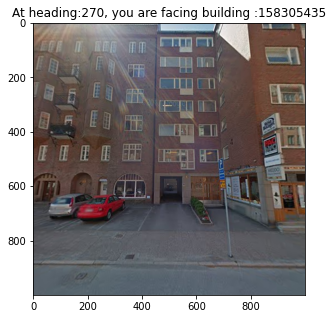

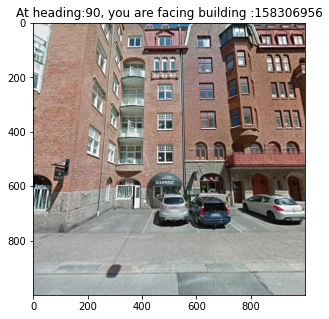

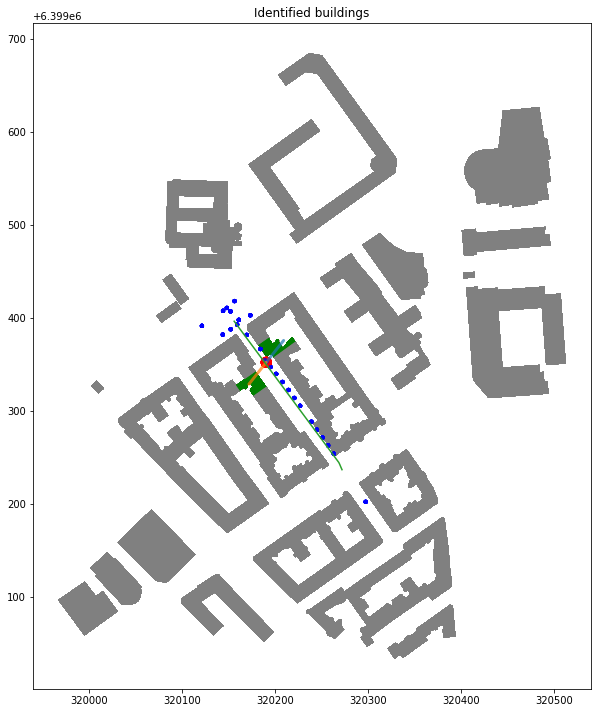

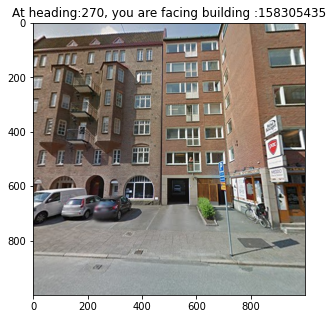

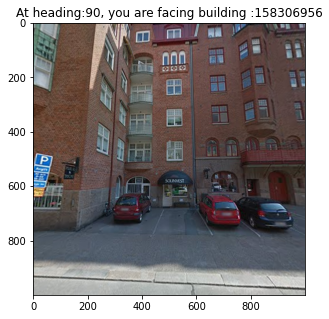

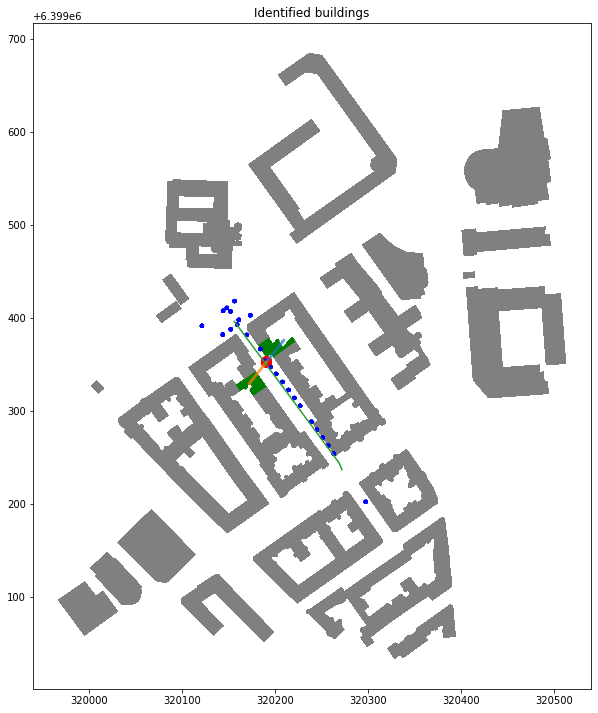

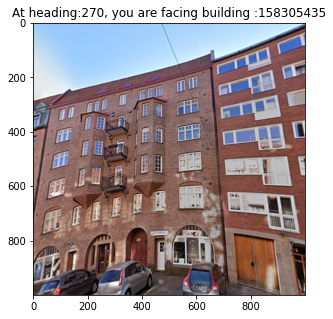

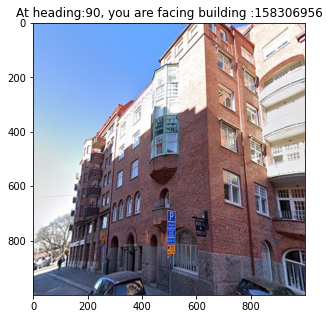

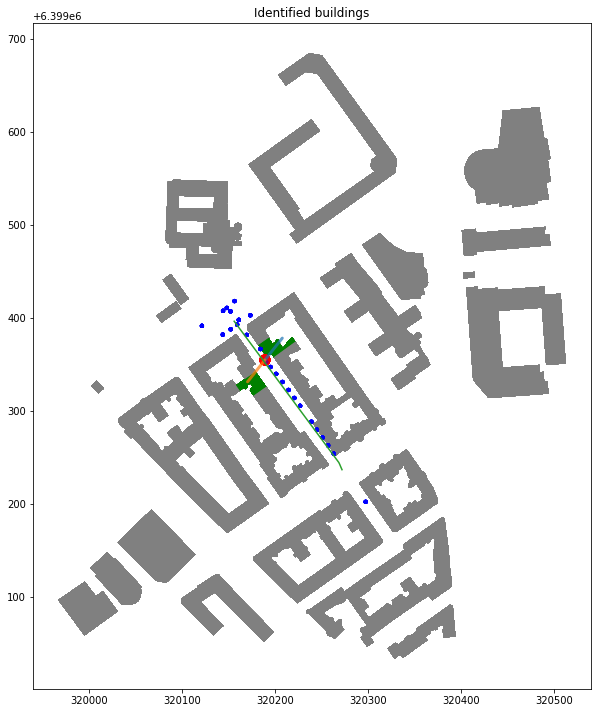

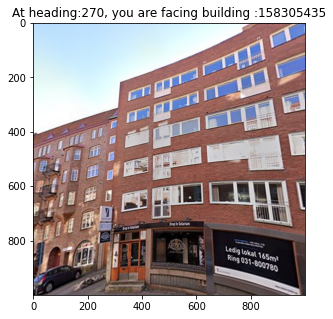

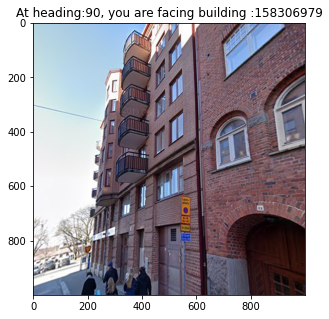

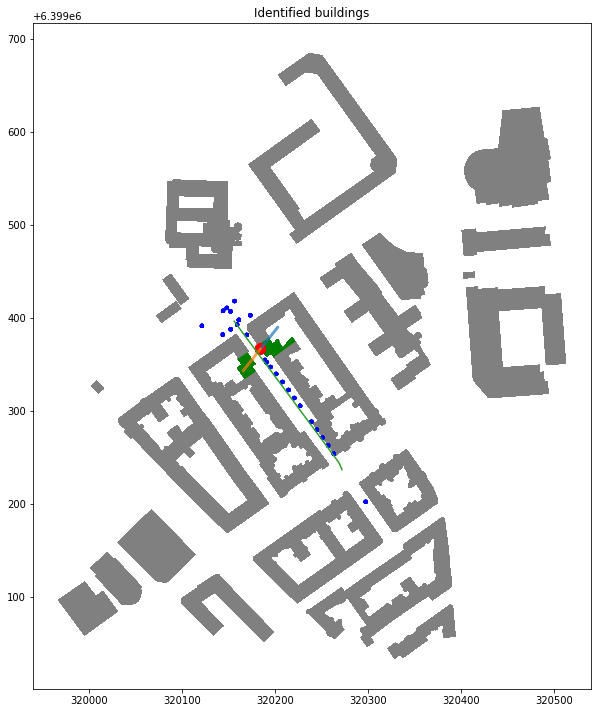

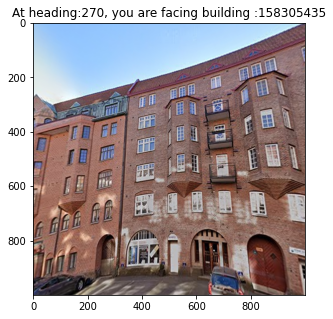

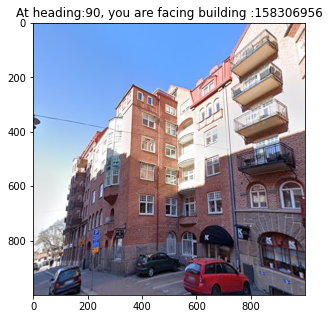

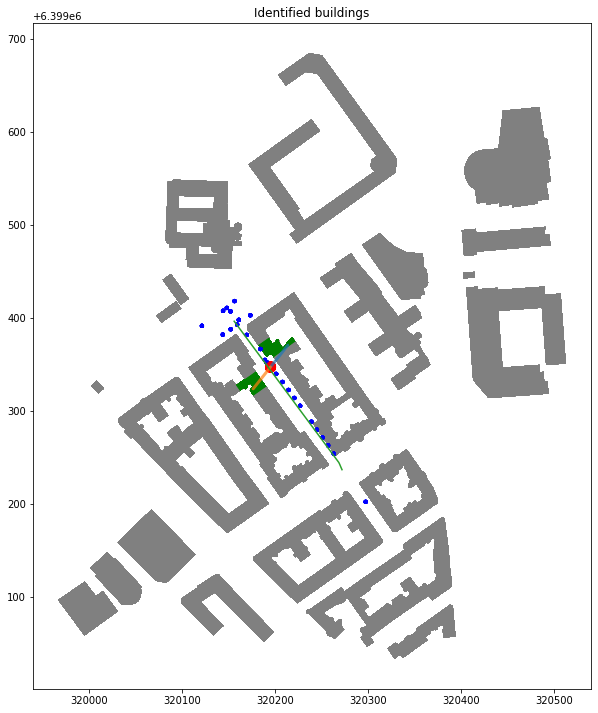

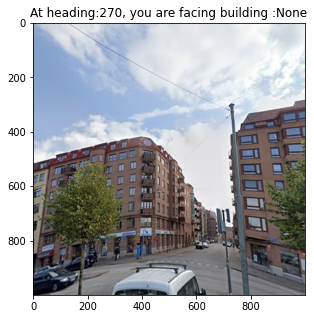

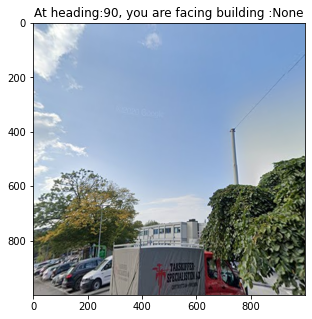

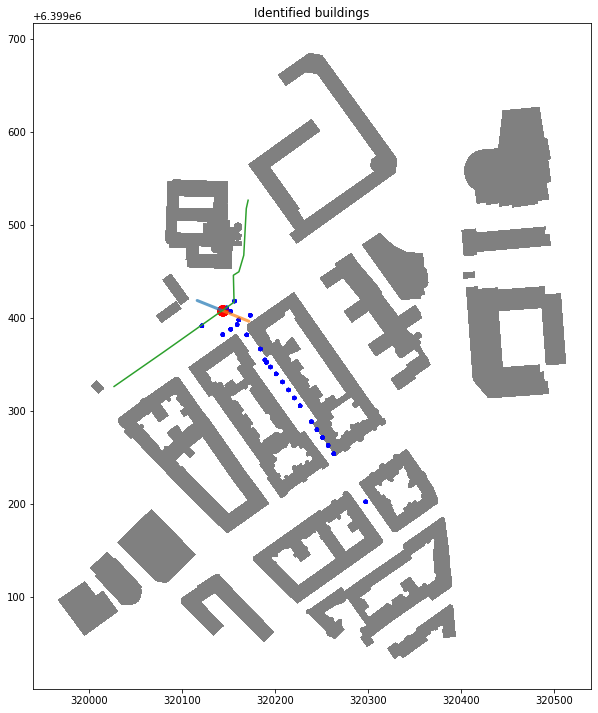

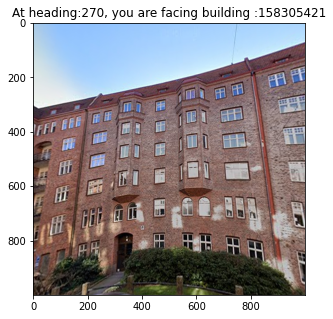

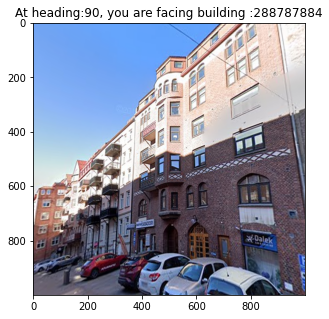

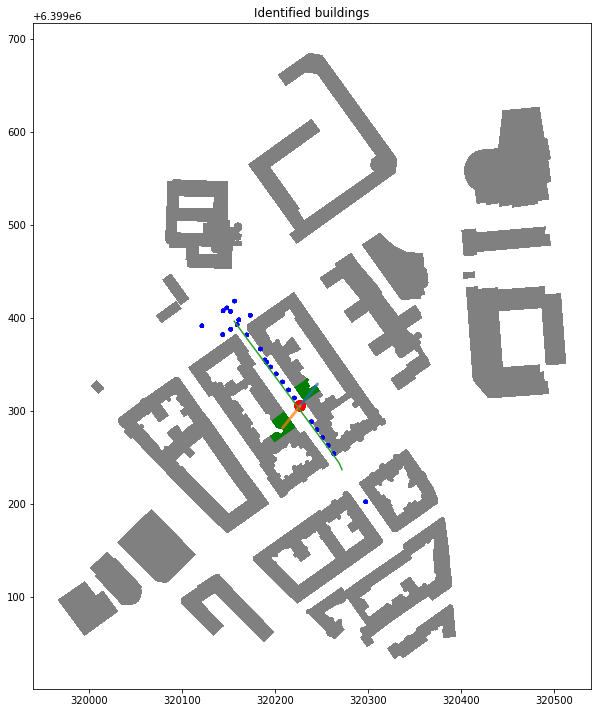

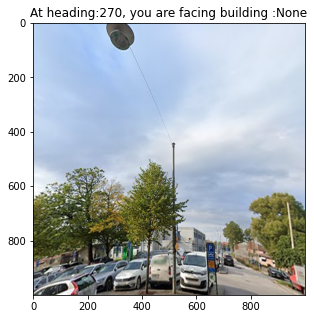

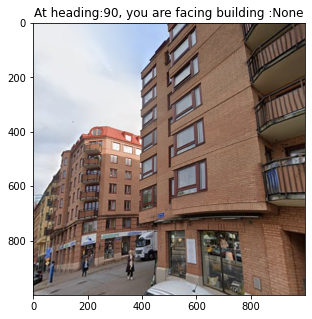

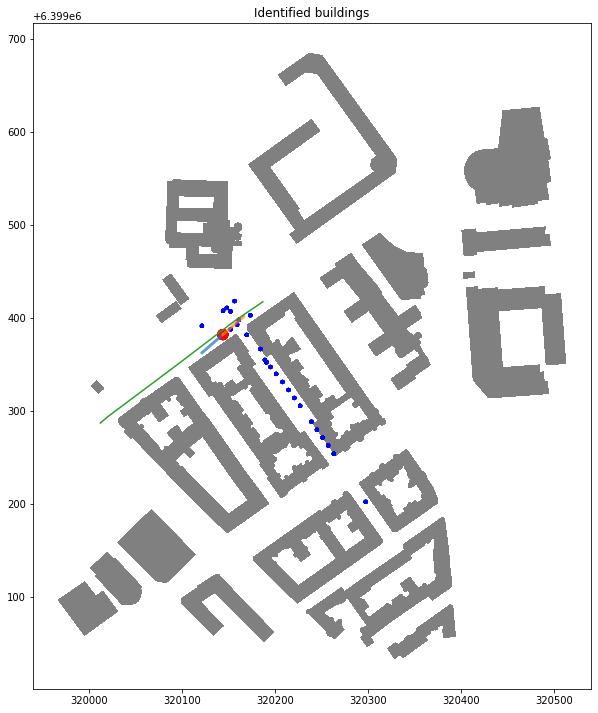

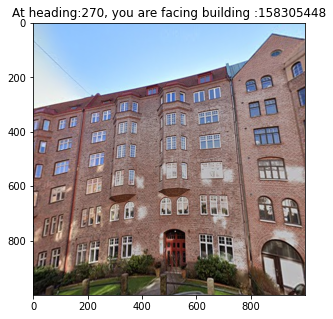

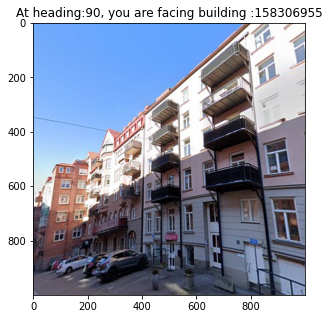

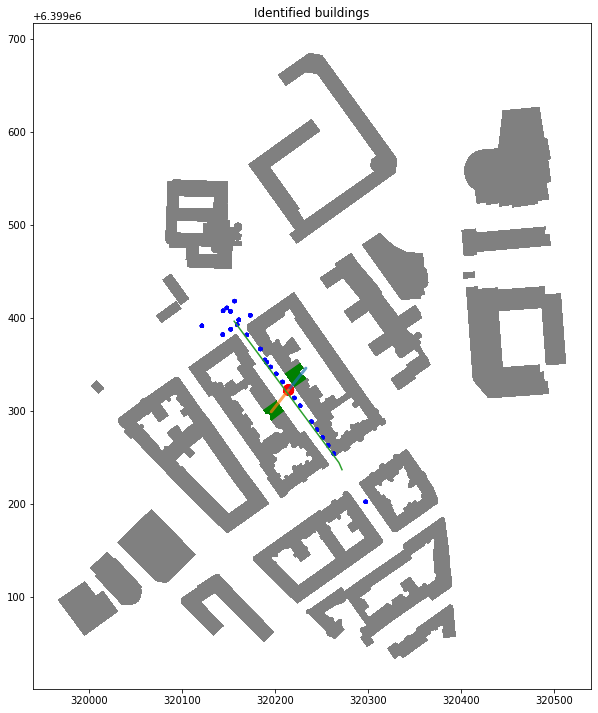

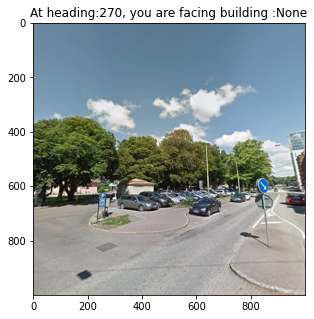

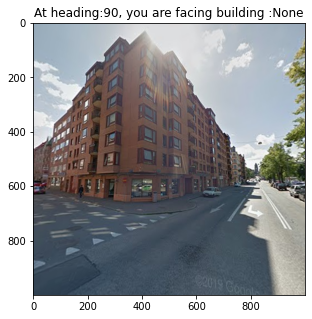

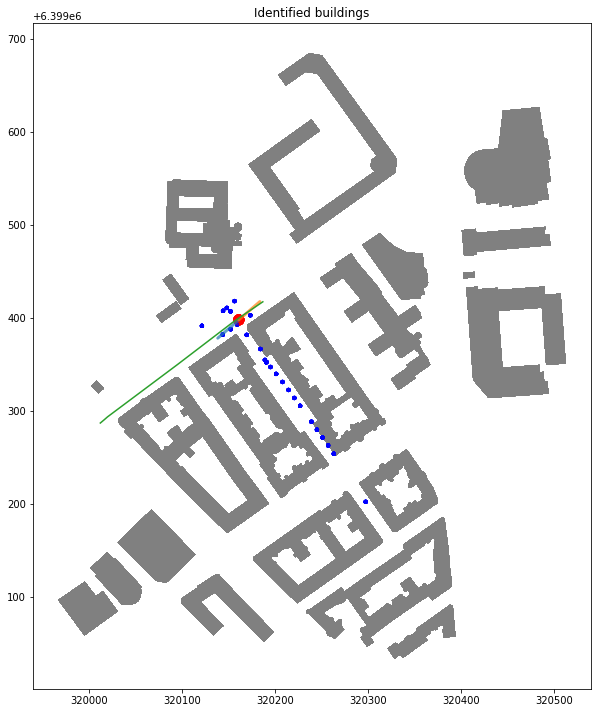

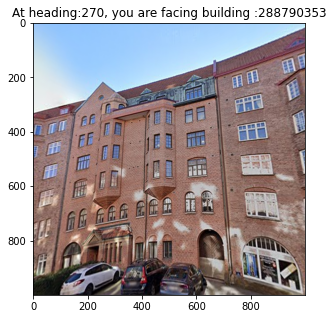

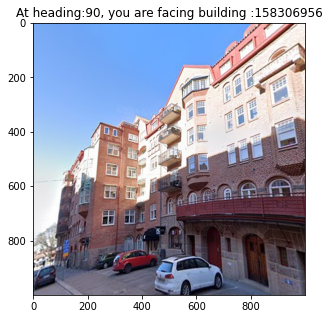

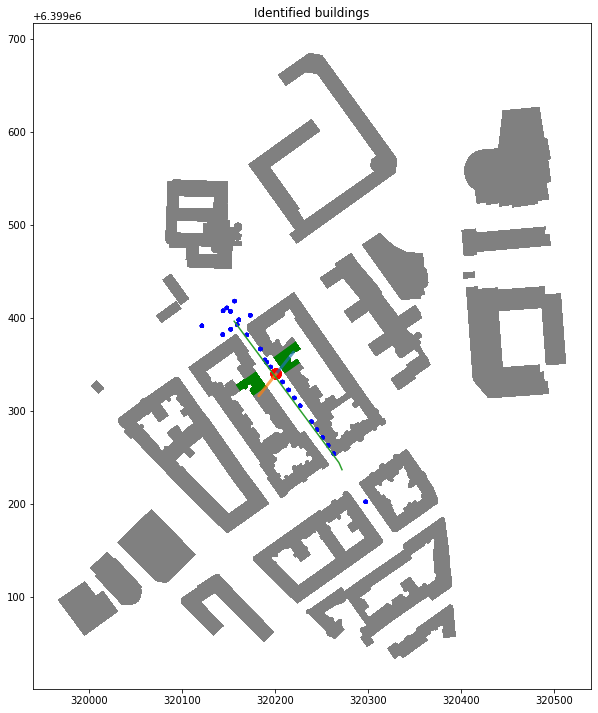

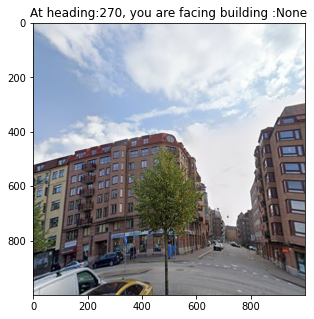

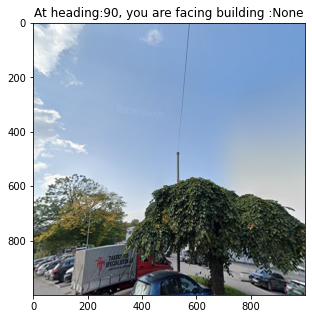

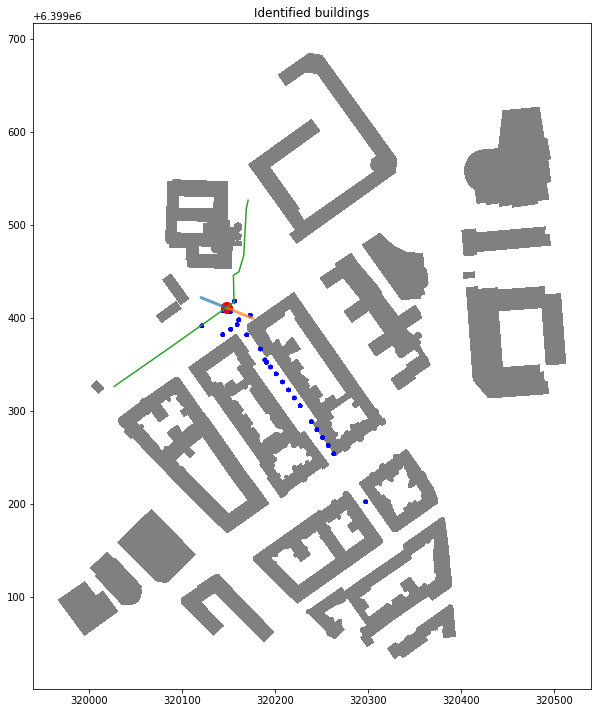

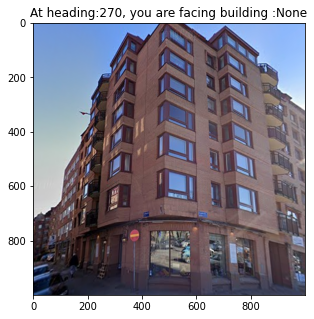

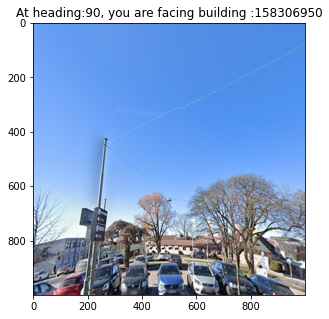

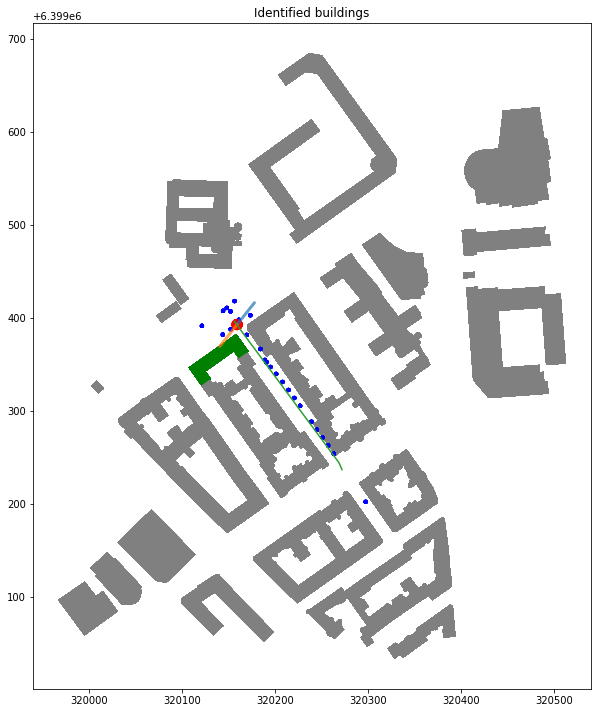

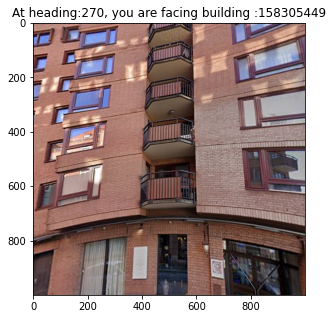

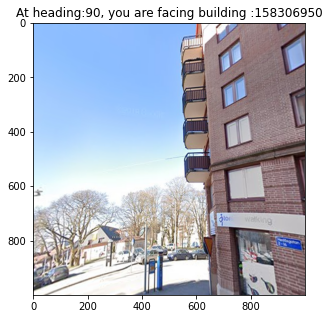

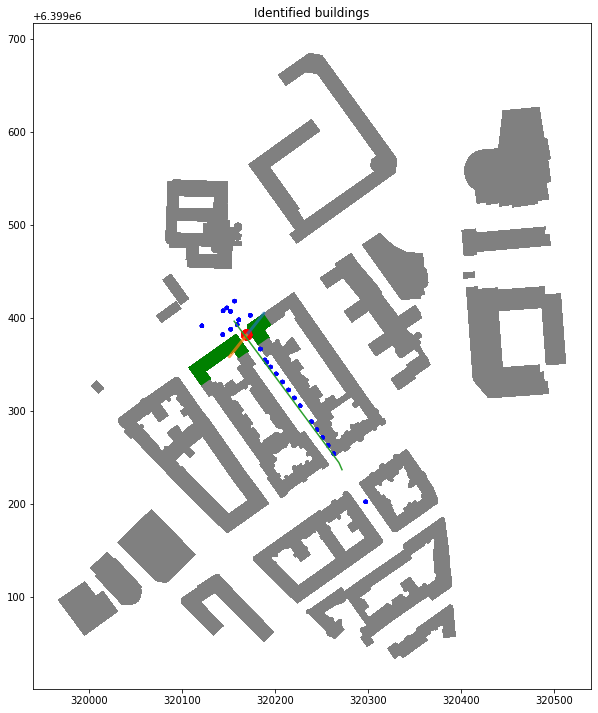

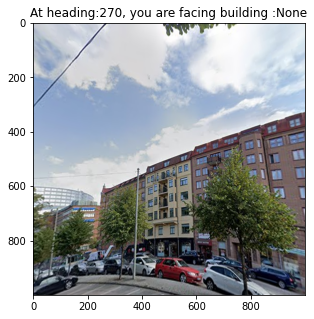

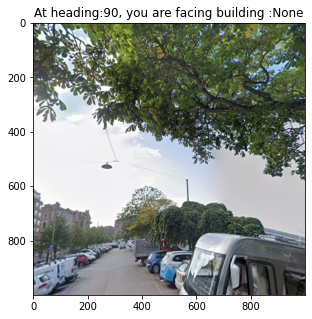

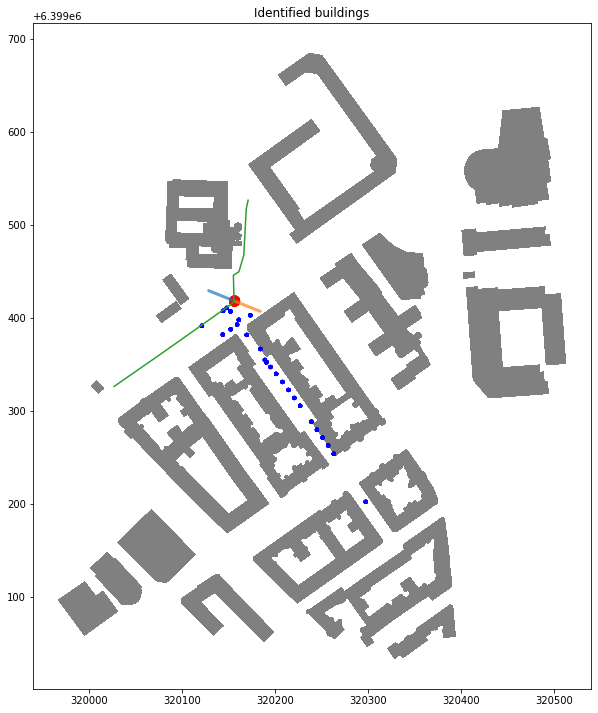

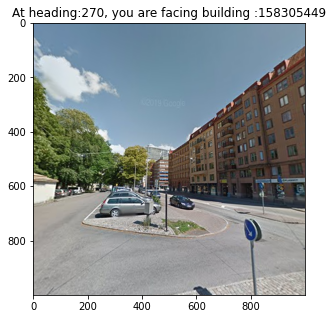

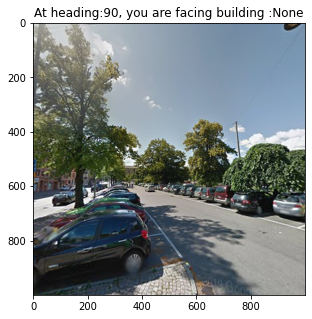

In [ ]:
for i in range(len(panoids)):
    get_image(lat=57.699064, 
              lon=11.983491,
              pano_sequence = i,
              fov=90,
              pitch = 10,
              height = 1000,
              width = 1000)